# 2.1 Toyota 

## 2.1.1

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer

np.random.seed(1)

In [49]:
df = pd.read_csv('../Tutorial 1/ToyotaCorolla.csv')

df = df.drop(columns=['Id', 'Model', 'Mfg_Month', 'Mfg_Year', 'Cylinders']) #, 'Doors'])
df['Fuel_Type'] = df['Fuel_Type'].astype('category')
df['Color'] = df['Color'].astype('category')
# df['Gears'] = df['Gears'].astype('category')
# df['Doors'] = df['Doors'].astype('category')

df.loc[df['CC'] == 16000, 'CC'] = 1600
df.rename(columns={'Age_08_04': 'Age'}, inplace=True)

for col in df.columns:
    if df[col].nunique() == 2:
        df[col] = df[col].astype('bool')

df = pd.get_dummies(df, drop_first=True)

In [50]:
numeric_features = df.select_dtypes(include=['number']).columns.tolist()
numeric_features.remove('Price')
print(numeric_features)

['Age', 'KM', 'HP', 'CC', 'Doors', 'Gears', 'Quarterly_Tax', 'Weight', 'Guarantee_Period']


Splitting the data into a trainnig and test set

In [51]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=1)

Making a pipe line with a standard scaler and (linear) regressor.

Regressing Price on Age

In [52]:
X = df_train[['Age']]        # In order to obtain a DataFrame rather than a Series, we use double brackets.
y = df_train['Price']

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

m = pipe.fit(X, y)

print(f"Coefficient Age: {m[1].coef_[0]:.4f}, Intercept: {m[1].intercept_:.4f}")

Coefficient Age: -3163.4678, Intercept: 10739.3593


Plotting predicted prices in the test set with the actual prices in the test set

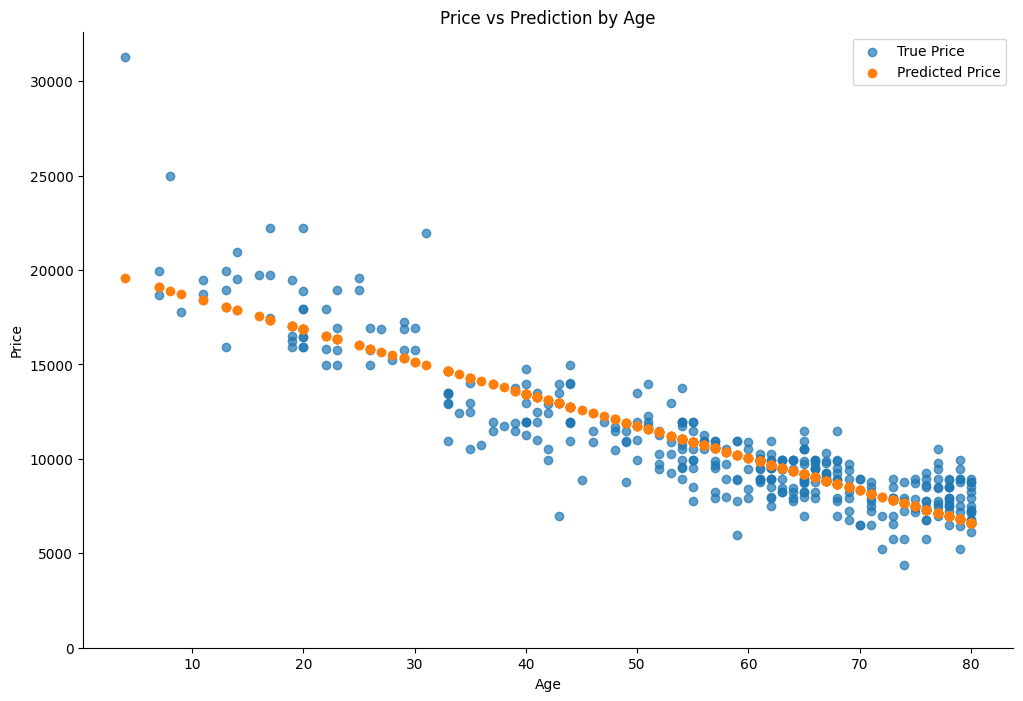

In [53]:
pred = m.predict(df_test[['Age']])
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter('Age', 'Price', data=df_test, label='True Price', alpha=0.7)
ax.scatter(df_test['Age'], pred, label='Predicted Price')
ax.set_title("Price vs Prediction by Age")
ax.set_xlabel("Age")
ax.set_ylabel("Price")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0)
ax.legend()
plt.plot();

The model performs bad for small values of `Age`.
The figure exhibits heteroskedasticity and some indications of endogeneity.

Perhaps this was meant:

There is one clear outlier. Predicted price is not higer than +-6500 (the lowest age)

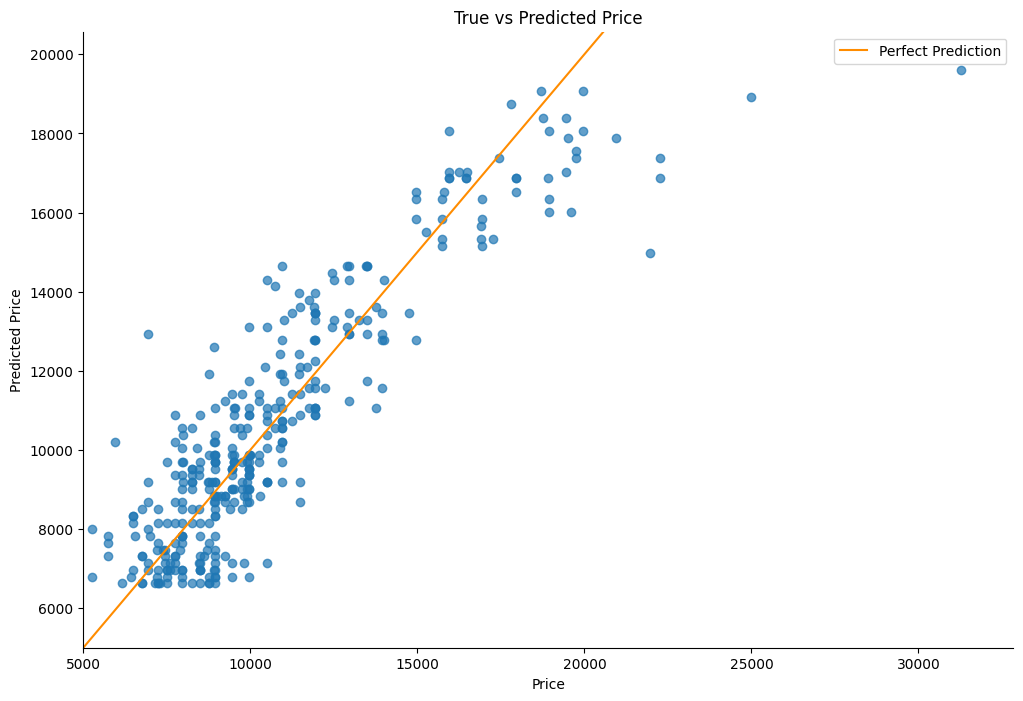

In [54]:
pred = m.predict(df_test[['Age']])
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(df_test['Price'],pred, alpha=0.7)
ax.axline([0, 0], [1, 1], color='darkorange', label='Perfect Prediction')
ax.set_title("True vs Predicted Price")
ax.set_ylabel("Predicted Price")
ax.set_xlabel("Price")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
ax.set_xlim(5000)
ax.set_ylim(5000)
plt.plot();

Computing the score of the of the pipeline

In [55]:
m.score(df_test[['Age']], df_test['Price'])

0.7932759309926051

### 5 fold cross validation

Without using `shuffle=True` the results are way off. This suggests the original dataframe is ordered in some manner.

The default `cv` argument for a regression model is KFold, with 5 splits. The default `scoring` argument is the default scorer of the model, which, in our case, is the R2, so the parameter is redundant.
We obtain a mean of $0.7666$, which is only a little bit lower than the test score above. The standard deviation is quite small. This indicates that the model is is stable, although a higher split and analysis of the estimated parameters would be needed to make such claims more substantial. 

In [62]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=12)
r2_scores = cross_val_score(m, df[['Age']], df['Price'], cv=kf, scoring='r2')
print(r2_scores)
print(f"Mean: {r2_scores.mean():.4f}  Std: {r2_scores.std():.4f}")

[0.76128887 0.75691448 0.77597853 0.75243376 0.7865845 ]
Mean: 0.7666  Std: 0.0127


## 2.1.2

In [65]:
X = pd.concat([df_train[['Age', 'ABS']], df_train.filter(like='Color_')], axis=1)
y = df_train['Price']

X['ABS x Age'] = X['ABS'] * X['Age']

# ABS and Color_{color} are binary features, so we don't need to scale them (i.e. pass them through)
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), ['Age', 'ABS x Age'])
], remainder='passthrough')

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

m2 = pipe.fit(X, y)

print("Estimated Coefficients:")

for i, name in enumerate(m2[0].feature_names_in_):
    if i % 4 == 0:
        print()
    print(f"{name:<20}{m2[1].coef_[i]:>10.4f}", end='\t')
print()

Estimated Coefficients:

Age                 -1781.8407	ABS                 -2154.1040	Color_Black          5194.7712	Color_Blue            -43.6777	
Color_Green          -430.2881	Color_Grey           -429.1833	Color_Red              69.4894	Color_Silver         -380.6825	
Color_Violet         -177.0549	Color_White          -358.2055	Color_Yellow        -1575.7868	ABS x Age            -947.1159	


When adding only ABS and Color dummies, coefficient of Age is only slightly lower.

However, to gauge whether the effect of age on a car with ABS, we need to look at the cross effect.

We see that the effect of age on a car with ABS is $-1782 - 947 = -2729$ compared to $-1782$ for a car without ABS.

This may be due to ABS being a technology that can break and has a costly repair, the older the car (and thus the ABS parts)
the likelier that the ABS technology is near the end of its lifecycle.

However, the model likely has OVB. The coefficient of ABS would intuitively be positive.

In [67]:
mean_age = np.mean(df['Age'])
mean_age_abs_1 = np.mean(df[df['ABS'] == 1]['Age'])
mean_age_abs_0 = np.mean(df[df['ABS'] == 0]['Age'])

print("Mean Age:", mean_age)
print("Mean Age when ABS == 1:", mean_age_abs_1)
print("Mean Age when ABS == 0:", mean_age_abs_0)

Mean Age: 55.94707520891365
Mean Age when ABS == 1: 52.269691780821915
Mean Age when ABS == 0: 71.97388059701493


Adding some coefficients like `KM` and `Doors` and categorical variables:

In [70]:
X = pd.concat([df_train[['Age', 'ABS', 'KM', 'Doors', 'Airco', 'Central_Lock']], df_train.filter(like='Color_')], axis=1)
y = df_train['Price']

preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), ['Age', 'KM', 'Doors'])
], remainder='passthrough')

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

m2 = pipe.fit(X, y)

print("Estimated Coefficients:")

for i, name in enumerate(m2[0].feature_names_in_):
    if i % 4 == 0:
        print()
    print(f"{name:<20}{m2[1].coef_[i]:>10.4f}", end='\t')
print()

Estimated Coefficients:

Age                 -2689.3820	ABS                  -667.1902	KM                    173.0108	Doors                -559.5977	
Airco                 476.0662	Central_Lock          591.7750	Color_Black           445.0265	Color_Blue            147.0303	
Color_Green           -75.7361	Color_Grey            538.6366	Color_Red             107.3956	Color_Silver          392.1666	
Color_Violet          914.2977	Color_White          -384.9363	Color_Yellow         -555.7080	


In [75]:
X_test = pd.concat([df_test[['Age', 'ABS', 'KM', 'Doors', 'Airco', 'Central_Lock']], df_test.filter(like='Color_')], axis=1)
y_test = df_test['Price']

print("Test R2 score: ", m2.score(X_test, y_test))

X_test = pd.concat([df[['Age', 'ABS', 'KM', 'Doors', 'Airco', 'Central_Lock']], df.filter(like='Color_')], axis=1)
y_test = df['Price']

print("\nCross-validation R2 scores:")
r2_scores = cross_val_score(m2, X_test, y_test, cv=kf) #, scoring='r2')
print(r2_scores)
print(f"Mean: {r2_scores.mean():.4f}  Std: {r2_scores.std():.4f}")

Test R2 score:  0.8253710069561488

Cross-validation R2 scores:
[0.79432733 0.80352573 0.81573772 0.79896187 0.83300869]
Mean: 0.8091  Std: 0.0139


The accurracy increases, but a positive coefficient on `km' does not make a whole lot of sense.

I don't quite understand the reshaping question. I didn't need to do that before either. The categorical variables do need to be encoded however, as sklearn does not handle them itself.

```{python}
data = pd.read_csv('../Tutorial 1/ToyotaCorolla.csv')

data = data.drop(columns=['Id', 'Model', 'Mfg_Month', 'Mfg_Year', 'Cylinders']) #, 'Doors'])
data['Fuel_Type'] = data['Fuel_Type'].astype('category')
data['Color'] = data['Color'].astype('category')

data.loc[data['CC'] == 16000, 'CC'] = 1600
data.rename(columns={'Age_08_04': 'Age'}, inplace=True)

X_train, y_train, X_test, y_test = train_test_split(data[['Age', 'ABS', 'Color', 'Fuel_Type', 'KM', 'Quarterly_Tax', 'Weight', 'HP']], data['Price'], test_size=0.25, random_state=1)

preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), ['Age', 'KM', 'Quarterly_Tax', 'Weight', 'HP']),
], remainder='passthrough')

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

m2 = pipe.fit(X_train, y_train)

print("Estimated Coefficients:")

for i, name in enumerate(m2[0].feature_names_in_):
    if i % 4 == 0:
        print()
    print(f"{name:<20}{m2[1].coef_[i]:>10.4f}", end='\t')
print()
```

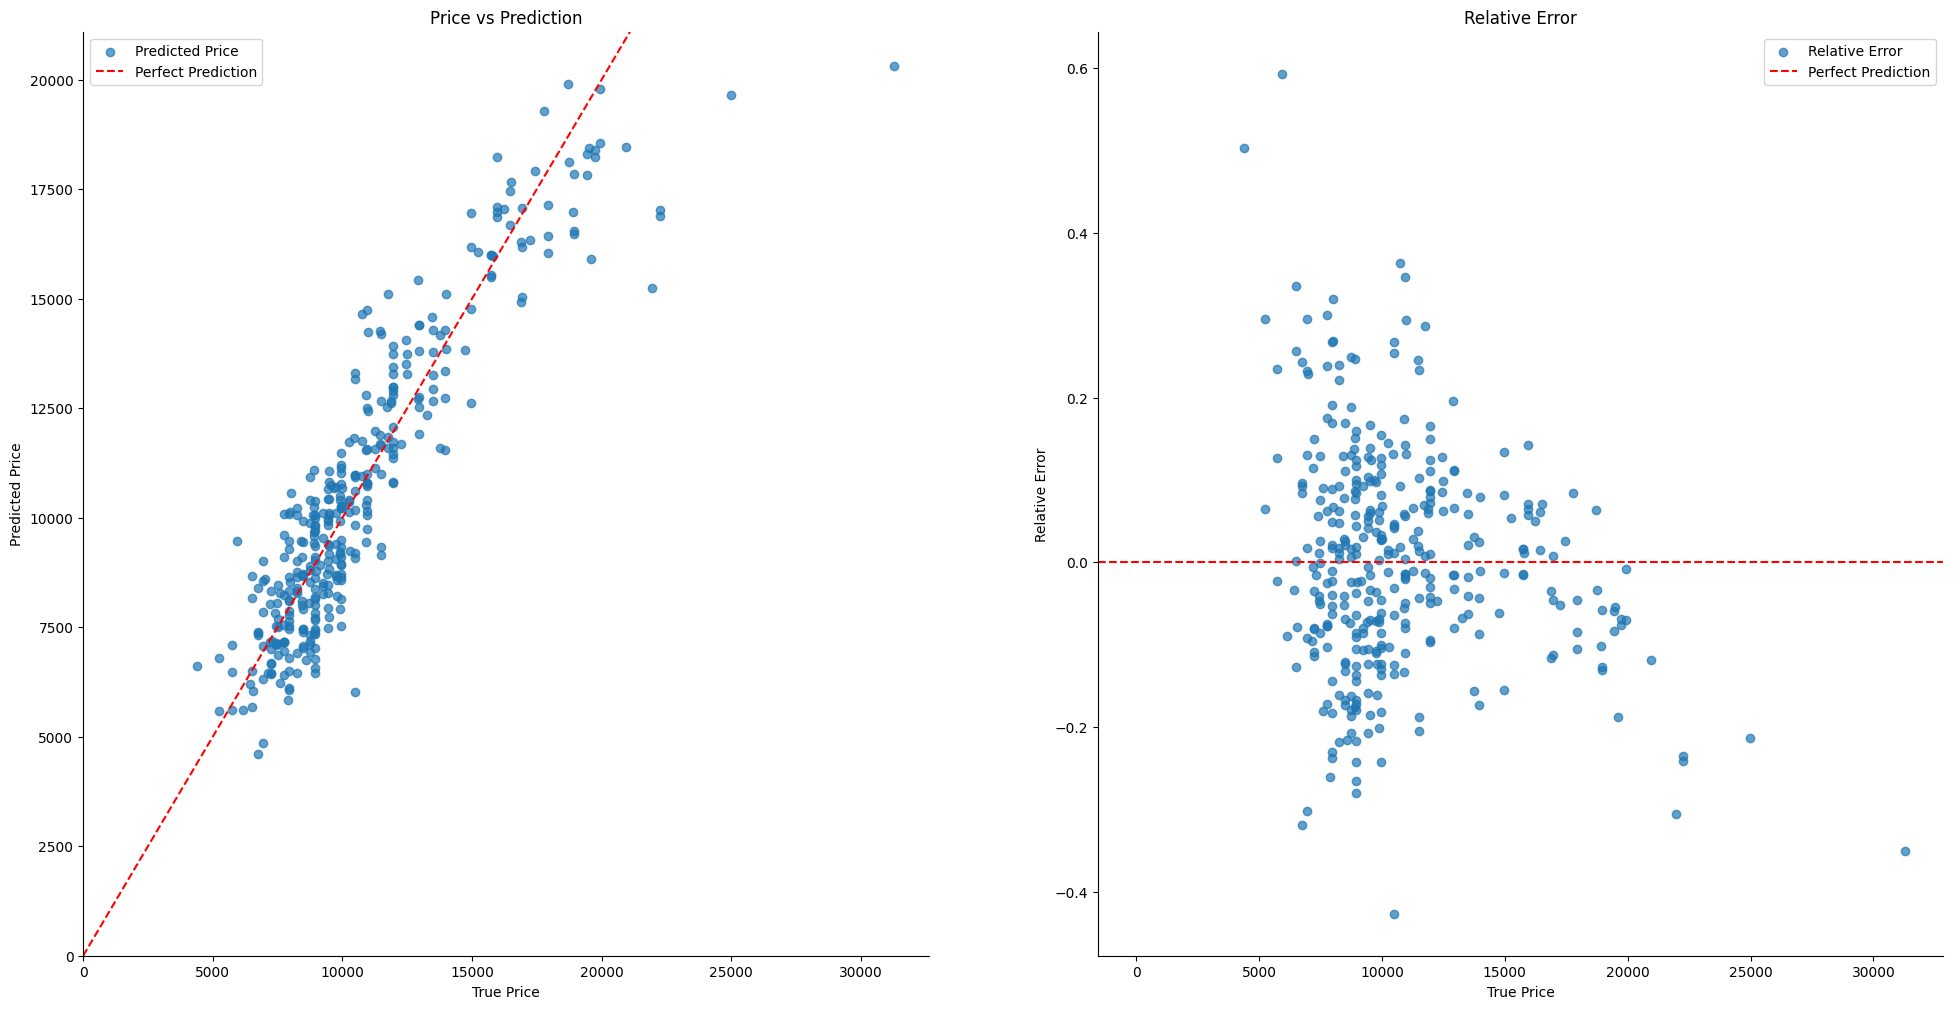

In [76]:
X_test = pd.concat([df_test[['Age', 'ABS', 'KM', 'Doors', 'Airco', 'Central_Lock']], df_test.filter(like='Color_')], axis=1)
y_test = df_test['Price']

pred = m2.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(24, 12))

axes[0].scatter(y_test, pred, label='Predicted Price', alpha=0.7)
axes[0].set_title("Price vs Prediction")
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xlim(0)
axes[0].set_ylim(0)
axes[0].axline([0, 0], [1, 1], color='red', linestyle='--', label='Perfect Prediction')
axes[0].set_ylabel("Predicted Price")
axes[0].set_xlabel("True Price")
axes[0].legend()
axes[1].scatter(y_test, pred/y_test - 1, label='Relative Error', alpha=0.7)
axes[1].set_title("Relative Error")
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].axline([0, 0], [1, 0], color='red', linestyle='--', label='Perfect Prediction')
axes[1].set_ylabel("Relative Error")
axes[1].set_xlabel("True Price")
axes[1].legend()
plt.plot();

### 2.1.6

No it's unlikely or impossible.


### 2.1.7
Regressing price directly on color... 

We can't. It would be a string variable. We'd still have to encode it with numerical values.

Of course it is bogus, instead I'll regress on all coefficients

Regression on all coefficients:

In [80]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), numeric_features)
], remainder='passthrough')

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

m3 = pipe.fit(df_train.drop(columns='Price'), df_train['Price'])

print("Estimated Coefficients:")

for i, name in enumerate(m3[0].feature_names_in_):
    if i % 4 == 0:
        print()
    print(f"{name:<20}{m3[1].coef_[i]:>10.4f}", end='\t')
print()

Estimated Coefficients:

Age                 -2111.7953	KM                   -609.0737	HP                    814.1528	Met_Color            -691.0416	
Automatic              88.9612	CC                      0.3494	Doors                 622.3601	Gears                 475.2576	
Quarterly_Tax         206.6480	Weight                -52.9462	Mfr_Guarantee         509.7454	BOVAG_Guarantee       226.6581	
Guarantee_Period      379.0223	ABS                  -175.4170	Airbag_1              -49.4368	Airbag_2             -178.2758	
Airco                 236.9304	Automatic_airco      2453.4855	Boardcomputer        -316.2014	CD_Player             241.5054	
Central_Lock           84.7941	Powered_Windows       249.8521	Power_Steering        148.8730	Radio                -243.3530	
Mistlamps              12.7537	Sport_Model           332.4900	Backseat_Divider     -169.2454	Metallic_Rim          238.4551	
Radio_cassette        173.9878	Parking_Assistant    -732.2979	Tow_Bar               -89.9341	Fuel_Ty

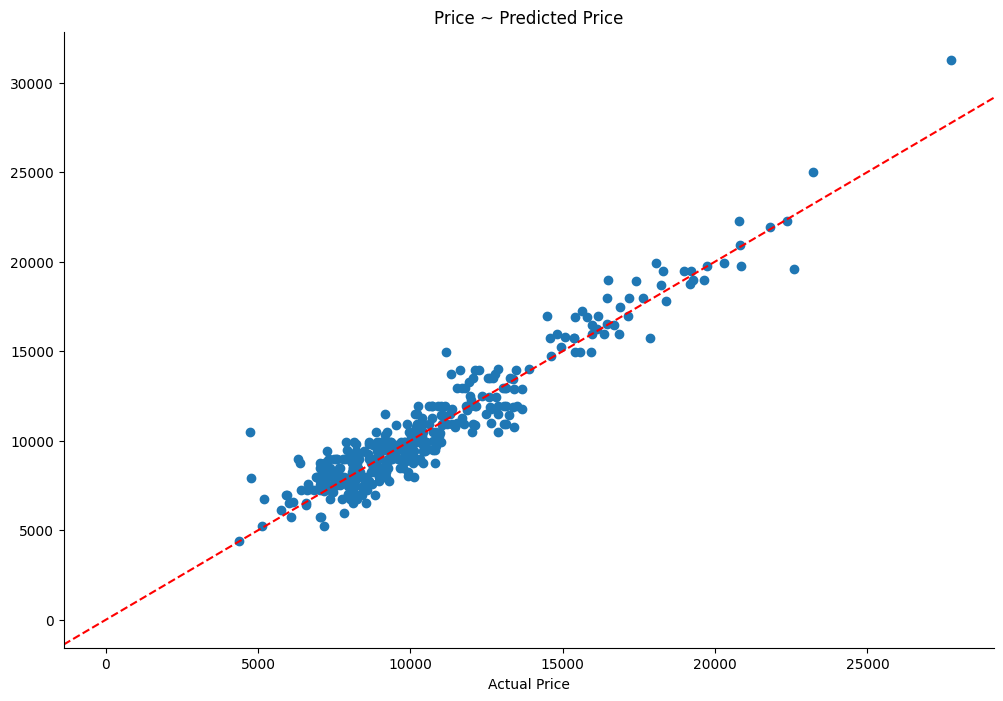

In [78]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(m3.predict(df_test.drop(columns='Price')), df_test['Price'])
ax.set_title("Price ~ Predicted Price")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Predicted Price")
ax.set_xlabel("Actual Price")

ax.axline((0, 0), slope=1, color='r', linestyle='--')
plt.plot();

In [79]:
cross_val_score(m3, df.drop(columns='Price'), df['Price'], cv=kf).mean()

np.float64(0.8949132850327983)

In [83]:
# yhat = m1.predict(df_test.drop(columns='Price'))

# horrible = df_test.iloc[np.where(yhat < 0)]

# # m1.predict(horrible.drop(columns='Price'))

# horrible.T

# The CC is insane. Should probably be 1600. 
# Also, wouldn't it make more sense for CC to have a positive coefficient?

I changed the CC to 1600 in the df generation code block.
Judging by the weight it is not a monster truck, I think it is fair.